This code snippet executes and analyses the shrinkage of target word sets from all stimuli datasets

In [1]:
import json
import os
import random

random.seed(1111)

from transformers import BertTokenizer

In [2]:
# import original stimuli datasets

TEST_EXT = '.jsonl'
all_tests = sorted([entry[:-len(TEST_EXT)]
                        for entry in os.listdir()
                        if not entry.startswith('.') and entry.endswith('word' + TEST_EXT)])

tests_original = {bias_test: {'targ1': None, 'targ2': None, 'attr1': None, 'attr2': None} for bias_test in all_tests}
tests_shrunken = {bias_test: {'targ1': None, 'targ2': None, 'attr1': None, 'attr2': None} for bias_test in all_tests}

for test in all_tests:
    file = json.load(open(test+TEST_EXT, 'r'))
    tests_original[test]['targ1'] = file['targ1']['examples_singular']
    tests_original[test]['targ2'] = file['targ2']['examples_singular']
    tests_original[test]['attr1'] = file['attr1']['examples_singular']
    tests_original[test]['attr2'] = file['attr2']['examples_singular']

In [3]:
# load BERT (bbu) tokenizer from local files
tokenizer = BertTokenizer.from_pretrained('../models/bert/base-uncased/')

In [4]:
def filter_stimuli(stimuli_lst, tokenizer):
    """ Function to shrinken word list """
    return [w.strip().lower() for w in stimuli_lst if w.strip().lower() in tokenizer.vocab]

for test in all_tests:
    # shrink orignial target word sets
    tests_shrunken[test]['targ1'] = filter_stimuli(tests_original[test]['targ1'], tokenizer)
    tests_shrunken[test]['targ2'] = filter_stimuli(tests_original[test]['targ2'], tokenizer)
    # save respective attribute word sets
    tests_shrunken[test]['attr1'] = tests_original[test]['attr1']
    tests_shrunken[test]['attr2'] = tests_original[test]['attr2']
    
    # target word sets have to be of equal size
    if len(tests_shrunken[test]['targ1']) != len(tests_shrunken[test]['targ2']):
        min_n = min([len(tests_shrunken[test]['targ1']), len(tests_shrunken[test]['targ2'])])
        # randomly sample min number of stimuli for both word sets
        if not len(tests_shrunken[test]['targ1']) == min_n:
            tests_shrunken[test]['targ1'] = random.sample(tests_shrunken[test]['targ1'], min_n)
        else:
            tests_shrunken[test]['targ2'] = random.sample(tests_shrunken[test]['targ1'], min_n)

In [5]:
# save word sets
for test in all_tests:
    # only save test if target word sets are not empty
    if len(tests_shrunken[test]['targ1']) > 0:
        with open('reduced_stimuli/'+test+'.jsonl', 'w') as file:
            json.dump(tests_shrunken[test], file,  indent=4)

Despite datasets containing stimuli which consist of multiple words, e.g. `C3_term_word`, there are no target stimuli left after shrinking for the bias tests `IBD_name_word` and `EIBD_name_word`. Further, `C9m_name_word` does not differ with respect to the target words from `C9_name_word` and thus the following analysis is conducted for the remaining bias tests:
- C1_name
- C3_name
- C6_name
- C6_term
- C9_name
- C9_term
- Occ_name
- Occ_term

In [40]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

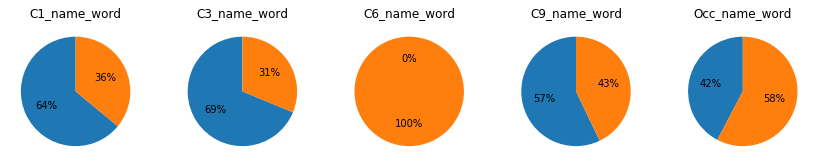

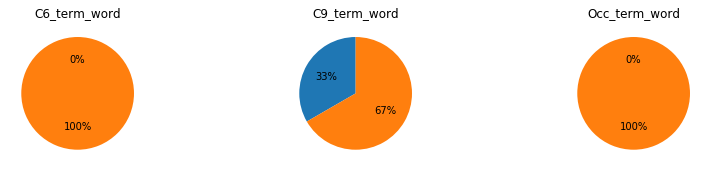

In [79]:
tests_name = ['C1_name_word', 'C3_name_word', 'C6_name_word', 'C9_name_word', 'Occ_name_word']
tests_term = ['C6_term_word', 'C9_term_word', 'Occ_term_word']
tests_remaining = tests_name + tests_term

leftover_percent = []
for test in tests_remaining:
    proportion = len(tests_shrunken[test]['targ1']) / len(tests_original[test]['targ1'])
    leftover_percent.append(proportion)

figure, axis = plt.subplots(1, 5)
for i in range(5):
    axis[i].pie([1-leftover_percent[i], leftover_percent[i]], startangle = 90, autopct='%1.0f%%')
    axis[i].set_title(tests_remaining[i])
figure.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])
plt.show()

figure, axis = plt.subplots(1, 3)
for i in range(5,8):
    axis[i-5].pie([1-leftover_percent[i], leftover_percent[i]], startangle = 90, autopct='%1.0f%%')
    axis[i-5].set_title(tests_remaining[i])
figure.tight_layout(pad=3.0, rect=[0, 0.64, 1, 0.95])
plt.show()

For `C6_name_word`, `C6_term_word`, and `Occ_term_word`, all stimuli exist in vocab and thus no shrinkage. For the remaining bias tests, the respective proportion of stimuli existent in the vocab is marked in blue.

In [82]:
for test in ['C1_name_word', 'C3_name_word', 'C9_name_word', 'C9_term_word', 'Occ_name_word']:
    number_stimuli = len(tests_shrunken[test]['targ1'])
    if number_stimuli < 8:
        print(test)

C9_name_word
C9_term_word


Further, for `C9_name_word` and `C9_term_word` less than 8 stimuli per target word set remain after the shrinkage. This indicates no statistically significant concept representation.

To conclude, only 6 out of 12 bias test are satisfactory after the shrinkage.